# Analyzing & Visualizing Data


* Visualizing store sales and transactions from Corporación Favorita, a large Ecuadorian-based grocery retailer.

* Analyzing the structures of data and extracting important information.

# Importing Packages

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path

In [2]:
# Plotting import
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

# Kaggle Learning tools for plot styles
from plotting.time_series.style import plot_params
from plotting.time_series.utils import (
    lagplot,
    make_lags,
    make_leads,
    plot_lags,
    plot_periodogram,
    seasonal_plot,
)


def printmd(string):
    """Helper function to print text in markdown format."""
    display(Markdown(string))

In [3]:

comp_dir = Path('../input/store-sales-time-series-forecasting')

# Importing Data

In [4]:
train_data = pd.read_csv(
    comp_dir / "train.csv", index_col="id", header=0, parse_dates=["date"]
)
stores_data = pd.read_csv(
    comp_dir / "stores.csv", index_col="store_nbr", header=0
)
transactions_data = pd.read_csv(
    comp_dir / "transactions.csv",
    index_col=None,
    header=0,
    parse_dates=["date"],
)

# Basics Statistical Information

We will look at simple aspects of sales to see which store, city, and state have the most sale on average.

In [5]:
total_records = train_data.shape[0]
first_date = train_data.date.iloc[0]
last_date = train_data.date.iloc[-1]
total_days = (train_data.date.iloc[-1] - train_data.date.iloc[0]).days
store_nbr_id = stores_data.index.values  # stores_data.store_nbr.unique()
family_unique = train_data.family.unique()

In [6]:
printmd("### Number of Records")
print(
    "{} from {} to {}".format(
        total_records, first_date.to_period("D"), last_date.to_period("D")
    )
)
print("(Total of {} days or {} months)".format(total_days, total_days // 30))
printmd("### Number of Stores")
print("{} stores".format(len(store_nbr_id)))
printmd("### Number of Product Family")
print("{} types".format(len(family_unique)))
printmd("### Number of Cities and States")
print(
    "{} cities in {} states".format(
        len(stores_data.city.unique()), len(stores_data.state.unique())
    )
)
# print( [stores_data.loc[store]['city'] for store in stores_data.index] )

### Number of Records

3000888 from 2013-01-01 to 2017-08-15
(Total of 1687 days or 56 months)


### Number of Stores

54 stores


### Number of Product Family

33 types


### Number of Cities and States

22 cities in 16 states


## Distribution of Store by City and State

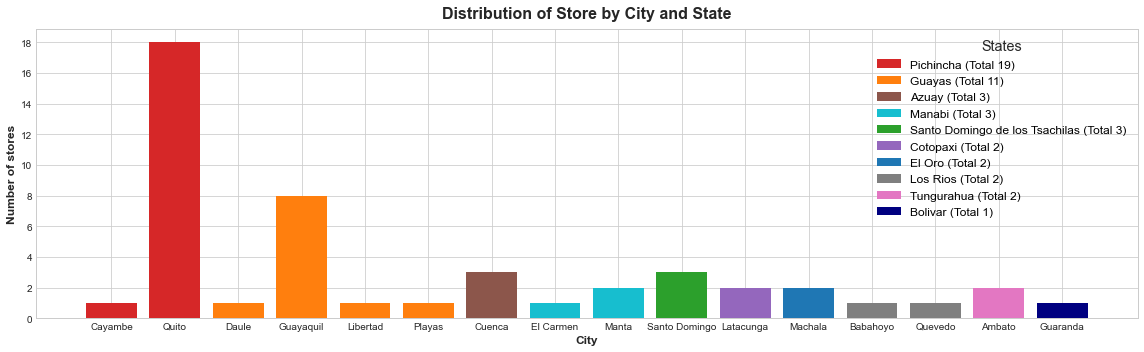

In [7]:
top_city = stores_data.groupby("city").size().sort_values(ascending=False)
top_state = stores_data.groupby("state").size().sort_values(ascending=False)
states = top_state.index.values

stores_data_grouped = stores_data.groupby(["state", "city"]).agg(
    {"city": "count"}
)
color = [
    "tab:red",
    "tab:orange",
    "tab:brown",
    "tab:cyan",
    "tab:green",
    "tab:purple",
    "tab:blue",
    "tab:gray",
    "tab:pink",
    "navy",
    "darkred",
]
fig, ax = plt.subplots(figsize=(16, 5))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Distribution of Store by City and State")
ax.set_ylabel("Number of stores")
ax.set_xlabel("City")
custom_label = []
custom_legend = []
for i in range(0, 10):
    u = stores_data_grouped.loc[states[i]]
    ax.bar(u.index.values, u.values.flatten(), color=color[i])
    custom_label.append(Patch(facecolor=color[i]))
    custom_legend.append(states[i] + " (Total {})".format(top_state[i]))
    
ax.legend(
    custom_label,
    custom_legend,
    fontsize="large",
    labelcolor="black",
    fancybox=True,
    title="States",
    title_fontsize="x-large",
)
plt.show()

### Conclusion: Distribution of Store by City and State

Only 5 states have more than 2 stores. From 10th states, there is only one store per state.

<hr style="height:2px;border-width:0;color:black;background-color:black">

## Daily Average Sales by All Store

Now we will see how the effectiveness of these stores and their locations. Below is the calculation of sales taking average daily for the whole period (of 1600 days)

In [8]:
sales_grouped = train_data.groupby(["store_nbr", "date"]).agg({"sales": "sum"})
sales_by_store_id = {}
for store in store_nbr_id:
    sales_by_store_id[store] = {
        "sale": sales_grouped.loc[store].sales.mean(),
        "city": stores_data.city[store],
        "city-id": stores_data.city[store] + "-{}".format(store),
        "state": stores_data.state[store],
        "type": stores_data.type[store],
        "cluster": stores_data.cluster[store],
    }

sales_by_store_id = pd.DataFrame.from_dict(
    sales_by_store_id, orient="index"
)  # convert to Pandas DataFrame

sales_by_city = {}
for city in top_city.index.values:
    sales_by_city[city] = {
        "sum": sales_by_store_id[stores_data.city == city].sale.sum(),
        "mean": sales_by_store_id[stores_data.city == city].sale.mean(),
    }
sales_by_city = pd.DataFrame.from_dict(sales_by_city, orient="index")

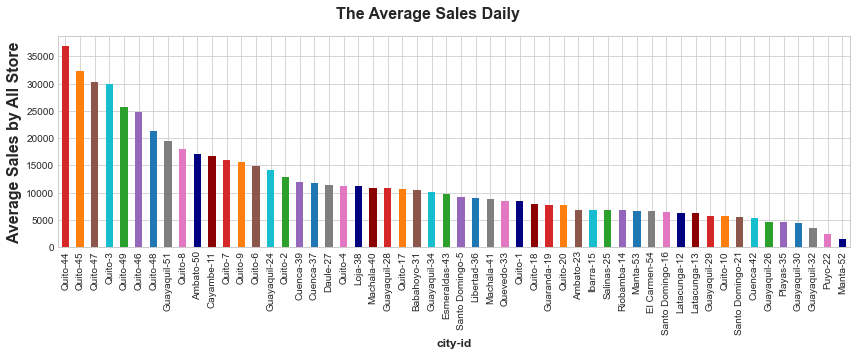

In [9]:
# Sorting
sales_by_store_id.sort_values(by="sale", inplace=True, ascending=False)
sales_by_city_sum = sales_by_city.sort_values(by="sum", ascending=False)

# Ploting
figsize = (12, 5)
fig, ax0 = plt.subplots(figsize=figsize)
sales_by_store_id.plot(
    kind="bar",
    x="city-id",
    y="sale",
    figsize=figsize,
    ax=ax0,
    color=color,
    align="center",
    legend=False,
)
plt.suptitle("The Average Sales Daily", fontsize=16, ha="center")
ax0.set_ylabel("Average Sales by All Store", fontsize=16)
plt.show()

### Conclusion: Daily Average Sales by All Store

There are 54 stores at different locations (including different cities and states). However, the averages of sales per day are not similar. Most effective stores are located in Quito city. There are also about 10 stores running badly. An available suggestion is to shut down these stores or look for effective solutions to improve the business.

<hr style="height:2px;border-width:0;color:black;background-color:black">

## Average Sales by City

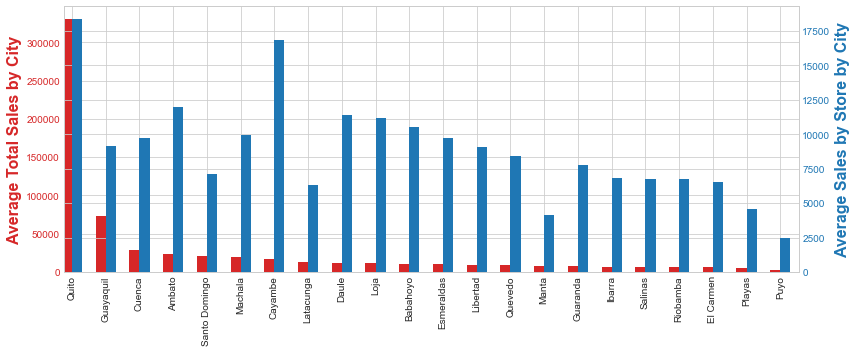

In [10]:
color1 = "tab:red"
color2 = "tab:blue"
fig, ax1 = plt.subplots(figsize=figsize)
sales_by_city_sum.plot(
    kind="bar",
    y="sum",
    figsize=figsize,
    ax=ax1,
    color=color1,
    align="edge",
    width=-0.3,
    legend=False,
)
ax2 = ax1.twinx()
sales_by_city_sum.plot(
    kind="bar",
    y="mean",
    figsize=figsize,
    ax=ax2,
    color=color2,
    align="edge",
    width=0.3,
    legend=False,
)

"""Style Set up"""
ax1.set_ylabel("Average Total Sales by City", color=color1, fontsize=16)
ax1.tick_params(axis="y", labelcolor=color1)
ax2.set_ylabel("Average Sales by Store by City", color=color2, fontsize=16)
ax2.tick_params(axis="y", labelcolor=color2)

### Conclusion: Average Sales by City

1. When looking at the graph by City, it's clear that Quito has the biggest daily-average sales both per city and per store. 

2. The second runer is Cayambe city where there is only 1 store. An available suggestion is to open more stores in this city.

<hr style="height:2px;border-width:0;color:black;background-color:black">

## Correlations among stores

In [11]:
"""Find Correlations among stores"""
a = train_data[["store_nbr", "sales"]]

# Create another column to index sales for each store by day by family
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index="ind", columns="store_nbr", values="sales").corr()

# Create upper triangle to hide in heatmap
mask = np.triu(a)

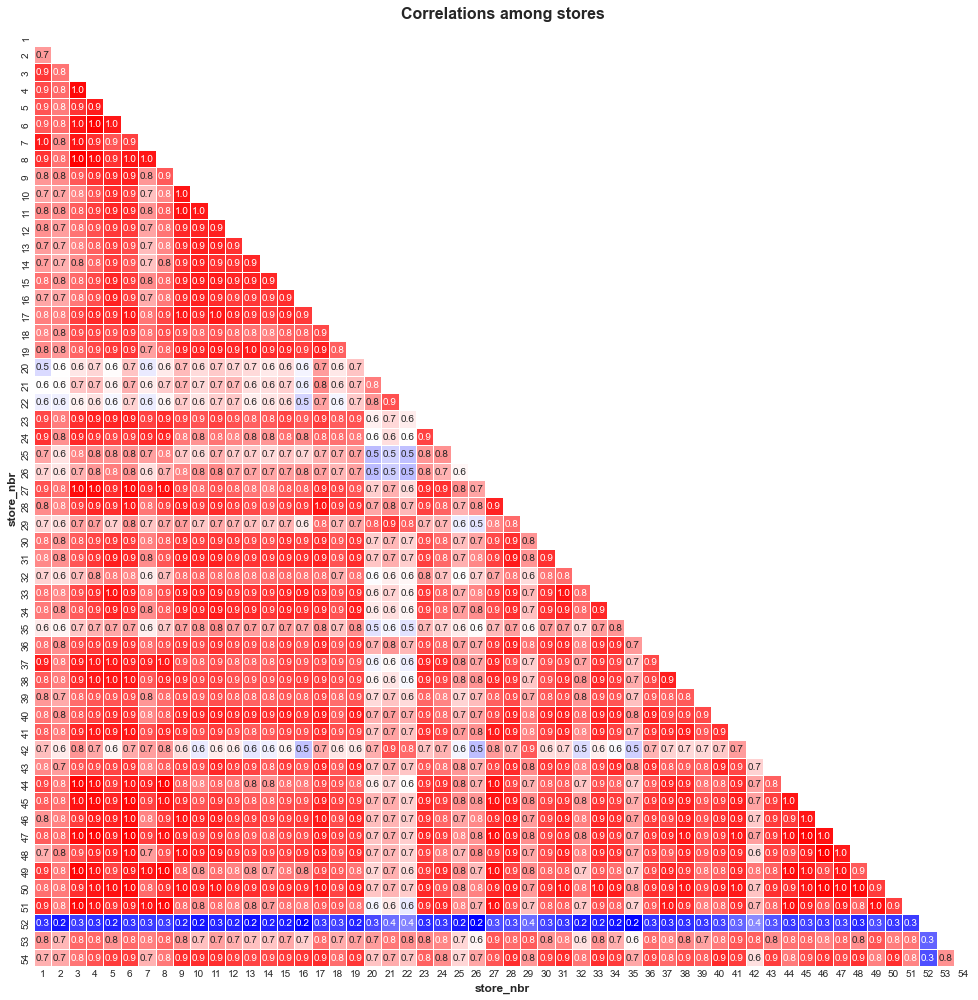

In [12]:
# Plot a heat map
plt.figure(figsize=(14, 14))
sns.heatmap(
    a,
    annot=True,
    fmt=".1f",
    cmap="bwr",
    square=True,
    mask=mask,
    linewidths=1,
    cbar=False,
)
plt.title("Correlations among stores", fontsize=16)
plt.show()

In [13]:
irreg_stores = [20, 21, 22, 25, 26, 29, 32, 35, 42, 52]
ss_sorted = sales_by_store_id.reset_index()

printmd("**Low correlation stores:**")
for store in irreg_stores:
    print(
        "Store #{} in ranking {}/54".format(
            store, ss_sorted.index[ss_sorted["index"] == store].tolist()[0] + 1
        )
    )

**Low correlation stores:**

Store #20 in ranking 35/54
Store #21 in ranking 47/54
Store #22 in ranking 53/54
Store #25 in ranking 38/54
Store #26 in ranking 49/54
Store #29 in ranking 45/54
Store #32 in ranking 52/54
Store #35 in ranking 50/54
Store #42 in ranking 48/54
Store #52 in ranking 54/54


### Conclusion: Correlations among stores

Most stores are highly correlations, meaning they are very similar in business and sales. However, there are few stores which are different from the others. By looking at the store by ranking, these stores are at the bottom in sales ranking. The business perhaps does not run well there.

<hr style="height:2px;border-width:0;color:black;background-color:black">

## Average Sales by Month & Quarter

In [14]:
sales_grouped = train_data.groupby("date").agg({"sales": "sum"}).to_period("D")
sales_grouped["year"] = sales_grouped.index.year
sales_grouped["quarter"] = sales_grouped.index.quarter
sales_grouped["month"] = sales_grouped.index.month
sales_grouped["week"] = sales_grouped.index.week
sales_grouped["dayofweek"] = sales_grouped.index.dayofweek  # Monday=0 Sunday=6
sales_grouped["dayofmonth"] = sales_grouped.index.day  # Day from 01 to 31
sales_grouped["dayofyear"] = sales_grouped.index.dayofyear

sales_smooth7 = sales_grouped.copy()
sales_smooth30 = sales_grouped.copy()
sales_smooth365 = sales_grouped.copy()

sales_smooth7["sales"] = sales_smooth7.sales.rolling(
    window=7, center=True, min_periods=3
).mean()

sales_smooth30["sales"] = sales_smooth30.sales.rolling(
    window=30, center=True, min_periods=15
).mean()

sales_smooth365["sales"] = sales_smooth365.sales.rolling(
    window=365, center=True, min_periods=183
).mean()

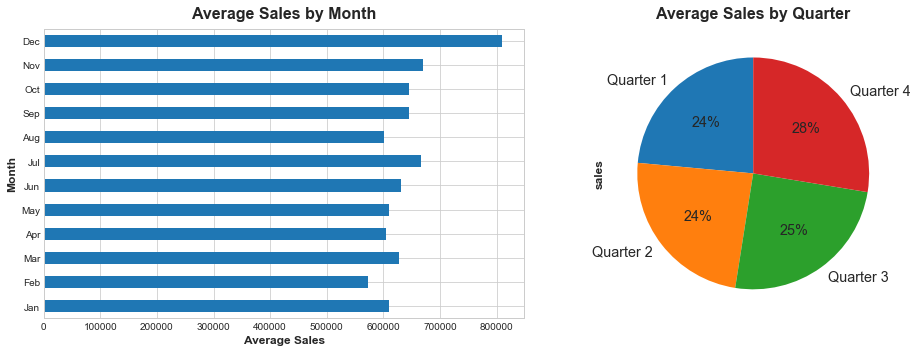

In [15]:
figsize = (14, 5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
sales_grouped.groupby(["month"]).agg({"sales": "mean"}).plot(
    kind="barh", ax=ax1
)
ax1.set(title="Average Sales by Month")
ax1.set(ylabel="Month", xlabel="Average Sales")
ax1.get_legend().remove()
labels1 = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
ax1.set_yticks(range(0, 12), labels1)

sales_grouped.groupby(["quarter"]).agg({"sales": "mean"}).plot.pie(
    y="sales",
    ax=ax2,
    legend=False,
    autopct="%1.f%%",
    startangle=90,
    labels=["Quarter 1", "Quarter 2", "Quarter 3", "Quarter 4"],
    fontsize="x-large",
)
ax2.set(title="Average Sales by Quarter")


plt.show()

### Conclusion

<table style=""><tr><td width="50%"  style="text-align:left;font-size: medium;vertical-align:top;background-color:#ffffff">

<h4>Average Sales by Month</h4>

Most of the sales occurred in December. People tend to stock for the end of the year to prepare for a new year or to decorate the house, or schedule for a long holiday starting from Christmas.
</td><td   style="text-align:left;font-size:medium;background-color:#ffffff;vertical-align:top;">
    
<h4>Average Sales by Quarter</h4>

Although the sales in each quarter are very similar, the last (4th) quarter is the biggist, which agrees to the sales by month where there is a jump in December.
</td></tr></table>

<hr style="height:2px;border-width:0;color:black;background-color:black;">

## Average Sales by Day in Week and Month

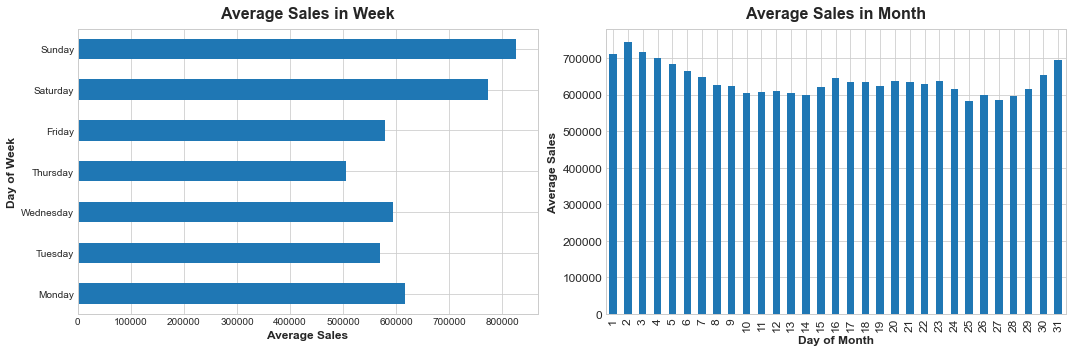

In [16]:
figsize = (15, 5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

sales_grouped.groupby(["dayofweek"]).agg({"sales": "mean"}).plot.barh(ax=ax1)
ax1.set(title="Average Sales in Week")
ax1.set(ylabel="Day of Week", xlabel="Average Sales")
ax1.get_legend().remove()
labels1 = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
ax1.set_yticks(range(0, 7), labels1)

sales_grouped.groupby(["dayofmonth"]).agg({"sales": "mean"}).plot.bar(
    ax=ax2, fontsize="large"
)
ax2.set(title="Average Sales in Month")
ax2.set(ylabel="Average Sales", xlabel="Day of Month")
ax2.get_legend().remove()

plt.show()

### Conclusion

<table style=""><tr><td width="50%"  style="text-align:left;font-size: medium;vertical-align:top;background-color:#ffffff">

<h4>Average Sales by Day in Week</h4>

Obviously, people spent more money on weekends than weekdays.

</td><td   style="text-align:left;font-size:medium;background-color:#ffffff;vertical-align:top;">
    
<h4>Average Sales by Day in Month</h4>

Despite people spending more money on weekends, the pattern in a month sticks out with a peak in the middle and high sales at the beginning and the end of a month. It is perhaps due to the dates people get paid in the public sector.
</td></tr></table>

<hr style="height:2px;border-width:0;color:black;background-color:black;">

## Top Product Families in 2017

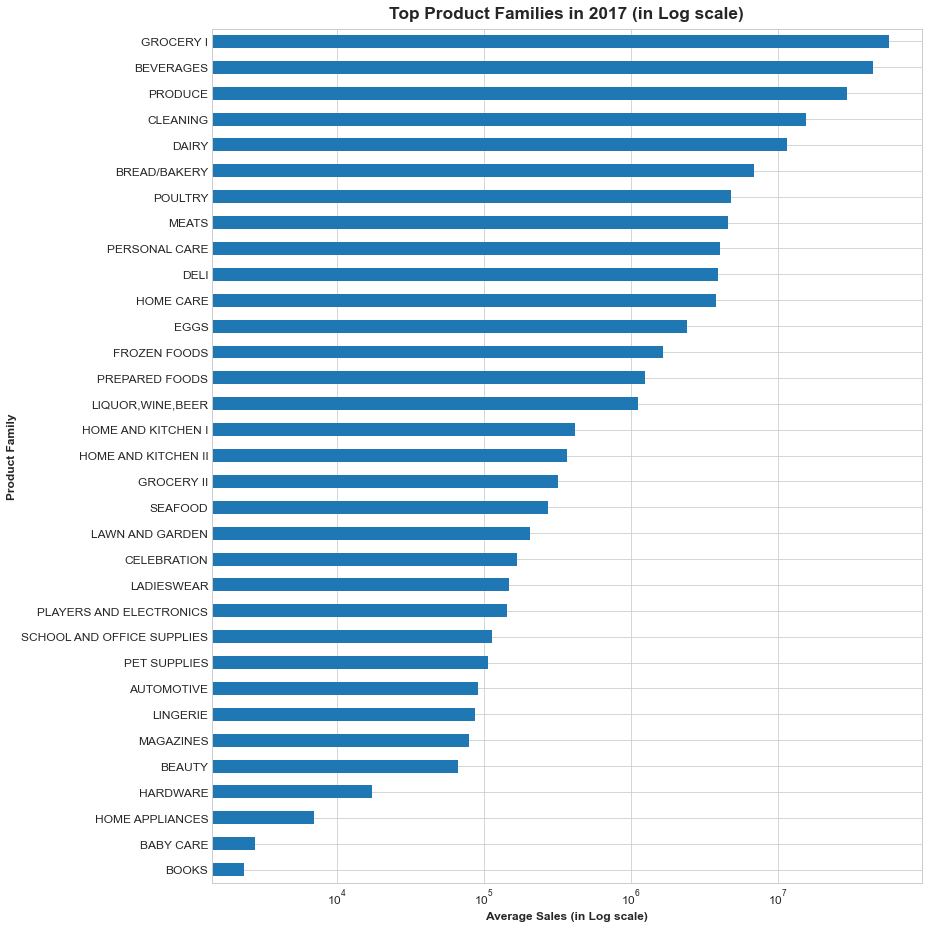

In [17]:
top_family = (
    train_data.loc[train_data.date.dt.year == 2017]
    .groupby(["family"])
    .agg({"sales": "sum"})
    .sort_values(by="sales", ascending=True)
)
figsize = (13, 13)
fig, ax1 = plt.subplots(figsize=figsize)
top_family.plot(kind="barh", ax=ax1)
ax1.set(title="Top Product Families in 2017 (in Log scale)")
ax1.set(
    ylabel="Product Family",
    xlabel="Average Sales (in Log scale)",
    xscale="log",
)
ax1.get_legend().remove()

for item in (
    [ax1.xaxis.label, ax1.yaxis.label]
    + ax1.get_xticklabels()
    + ax1.get_yticklabels()
):
    item.set_fontsize("large")
ax1.title.set_fontsize("xx-large")
plt.show()

### Conclusion: Top Product Families in 2017

Note that the plot in the Log scale shows all the sales by all product families because some of them had very small sales in comparison to other types.

Highest sales are made by the product families like grocery and beverages.

<hr style="height:2px;border-width:0;color:black;background-color:black">

## Top Sales by Type and Cluster in 2017

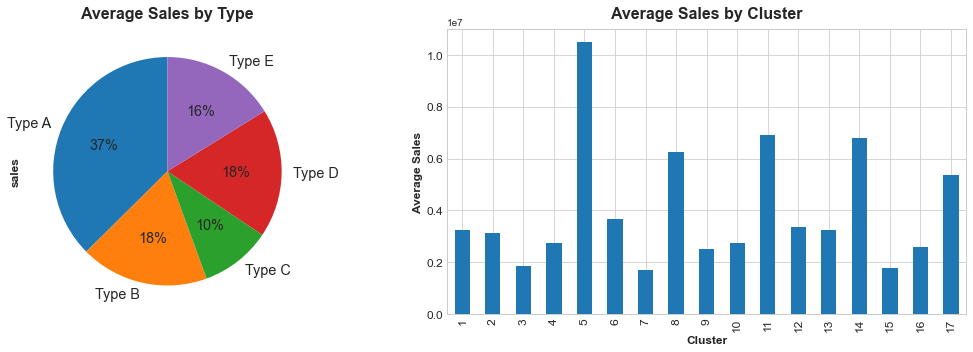

In [18]:
top_stores_2017 = (
    train_data.loc[train_data.date.dt.year == 2017]
    .groupby("store_nbr")
    .agg({"sales": "sum"})
)
top_stores_2017 = pd.merge(top_stores_2017, stores_data, on="store_nbr").drop(
    ["city", "state"], axis=1
)

figsize = (15, 5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
top_stores_2017.groupby(["type"]).agg({"sales": "mean"}).plot.pie(
    y="sales",
    ax=ax1,
    legend=False,
    autopct="%1.f%%",
    startangle=90,
    labels=["Type A", "Type B", "Type C", "Type D", "Type E"],
    fontsize="x-large",
)
ax1.set(title="Average Sales by Type")

top_stores_2017.groupby(["cluster"]).agg({"sales": "mean"}).plot.bar(
    ax=ax2, fontsize="large"
)
ax2.set(title="Average Sales by Cluster")
ax2.set(ylabel="Average Sales", xlabel="Cluster")
ax2.get_legend().remove()

plt.show()

### Conclusion: Top Sales by Type and Cluster in 2017

* Store Type A has the highest sales which is 37%, followed by Types B and D.

* Store Cluster 5 has the highest sales, followed by Clusters 11, 14, and 8.

<hr style="height:2px;border-width:0;color:black;background-color:black">

# Visualization of Seasonality and Trend

We would like to know how the sales behave at different times to understand their seasonality and the overall trend. Seasonalities include each season, monthly, quarterly.

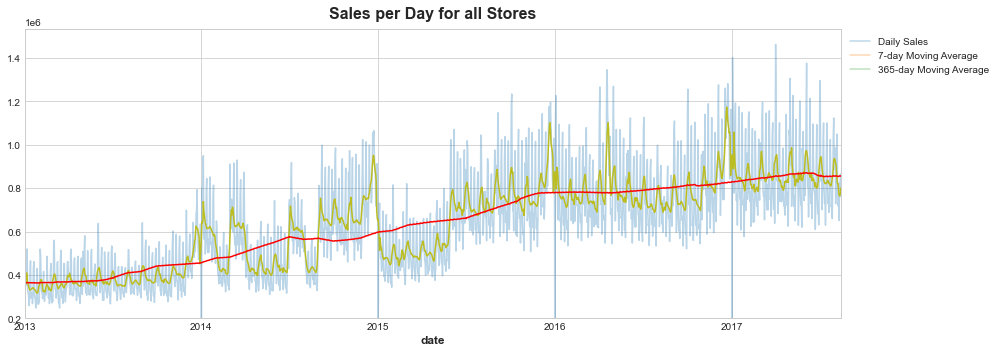

In [19]:
figsize = (14, 5)
fig, ax = plt.subplots(figsize=figsize)
sales_grouped.plot(ax=ax, alpha=0.3)
sales_smooth7.plot(ax=ax)
sales_smooth365.plot(ax=ax, color="r")
ax.legend(
    ["Daily Sales", "7-day Moving Average", "365-day Moving Average"],
    bbox_to_anchor=(1.0, 1.0),
)
ax.set(ylim=2e5, title="Sales per Day for all Stores")
plt.show()

### Conclusion: Sales per Day for all Stores

Based on the above graph, we could see the sales were peaking at every new-year time.

<hr style="height:2px;border-width:0;color:black;background-color:black">

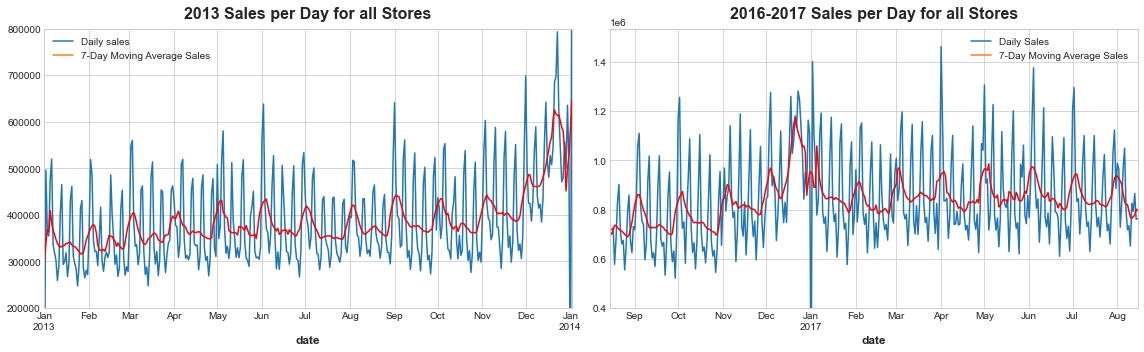

In [20]:
figsize = (16, 5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
sales_grouped.plot(ax=ax1)
sales_smooth7.plot(ax=ax1, color="r")
ax1.legend(["Daily sales", "7-Day Moving Average Sales"])
ax1.set(ylim=[2e5, 8e5], title="2013 Sales per Day for all Stores")
ax1.set(xlim=[sales_grouped.index[0], sales_grouped.index[365]])

sales_grouped.plot(ax=ax2)
sales_smooth7.plot(ax=ax2, color="r")
ax2.legend(["Daily Sales", "7-Day Moving Average Sales"])
ax2.set(ylim=4e5, title="2016-2017 Sales per Day for all Stores")
ax2.set(xlim=[sales_grouped.index[-365], sales_grouped.index[-1]])
plt.show()

### Conclusion: Sales in period of 365 days

Based on zoomed-in graphs, we could see 12 peaks of sales for 365 days (equivalently 12 months or a year). Hence, there is a monthly frequency. Moreover, the sales increased dramatically during the transition times from the preview year to the new year which presented an annual pattern. (The sales were smoothed with 7-day MA to eliminate the weekly pattern)

<hr style="height:2px;border-width:0;color:black;background-color:black">

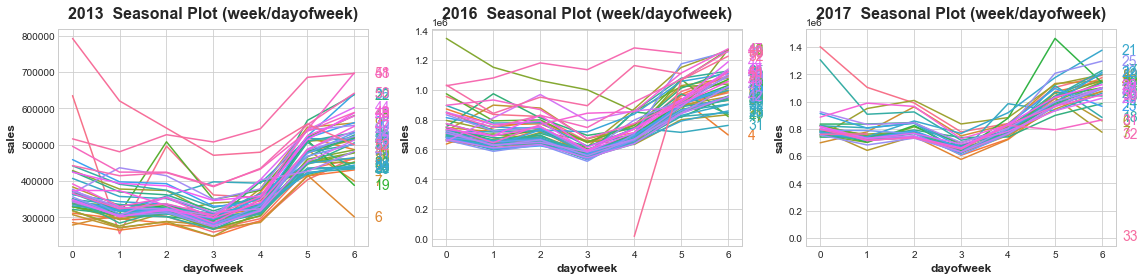

In [21]:
figsize = (16, 4)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
seasonal_plot(
    sales_grouped.loc[sales_grouped["year"] == 2013],
    y="sales",
    period="week",
    freq="dayofweek",
    ax=ax1,
    atext="2013 ",
)
seasonal_plot(
    sales_grouped.loc[sales_grouped["year"] == 2016],
    y="sales",
    period="week",
    freq="dayofweek",
    ax=ax2,
    atext="2016 ",
)
seasonal_plot(
    sales_grouped.loc[sales_grouped["year"] == 2017],
    y="sales",
    period="week",
    freq="dayofweek",
    ax=ax3,
    atext="2017 ",
)
plt.show()

### Conclusion: Seasonality: Weekly

There was a pattern for weekly sales in which weekends had more sales than weekdays. It makes sense because people are off on weekends and have available time to spend money.

<hr style="height:2px;border-width:0;color:black;background-color:black">

Next, we will see how about a monthly pattern. Before that, we have to smooth the data to minimize the weekly patterns.

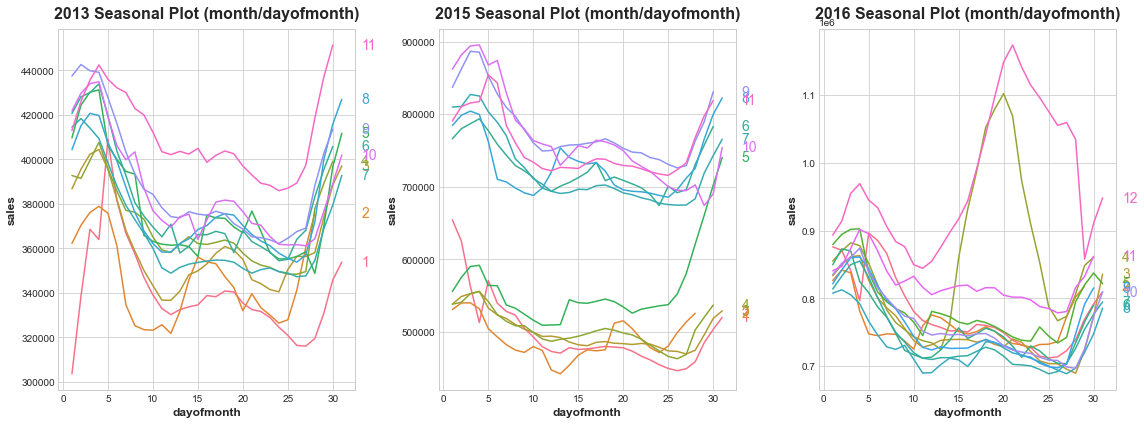

In [22]:
sales_smooth = sales_smooth7.copy()
figsize = (16, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
seasonal_plot(
    sales_smooth.loc[
        (sales_smooth["year"] == 2013) & (sales_smooth["month"] != 12)
    ],
    y="sales",
    period="month",
    freq="dayofmonth",
    ax=ax1,
    atext="2013",
)
seasonal_plot(
    sales_smooth.loc[
        (sales_smooth["year"] == 2015) & (sales_smooth["month"] != 12)
    ],
    y="sales",
    period="month",
    freq="dayofmonth",
    ax=ax2,
    atext="2015",
)
seasonal_plot(
    sales_smooth.loc[sales_smooth["year"] == 2016],
    y="sales",
    period="month",
    freq="dayofmonth",
    ax=ax3,
    atext="2016",
)
plt.show()

### Conclusion: Seasonality: Monthly

The behavior of the last month of the year is shown in the last figure (on the right). By eliminating this month, we can see a strong monthly pattern for sales. 

1. There were 2 troughs. The sales went down to trough around days 10 and 25 
2. There were 2 peaks. The sales went up to the biggest peak at the end of the month. There was a minor peak at around days 15 to 20.

<hr style="height:2px;border-width:0;color:black;background-color:black">

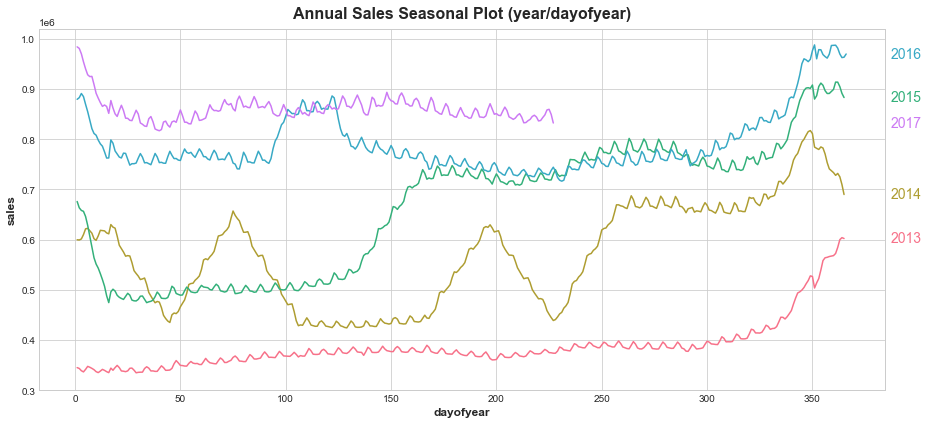

In [23]:
sales_smooth = sales_smooth30.copy()
figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)
seasonal_plot(
    sales_smooth,
    y="sales",
    period="year",
    freq="dayofyear",
    ax=ax,
    atext="Annual Sales",
)
ax.set(ylim=3e5)
plt.show()

### Conclusion: Seasonality: Annually

After smoothing the data in a period of 30 days to eliminate the impact of monthly and weekly seasonalities, we can conclude that the sales were rising by the end of each year and slowly went down after the new year period. During 2014, the price of crude oil was in trouble, hence, could influence the business and caused abnormal peaks of sales.

<hr style="height:2px;border-width:0;color:black;background-color:black">

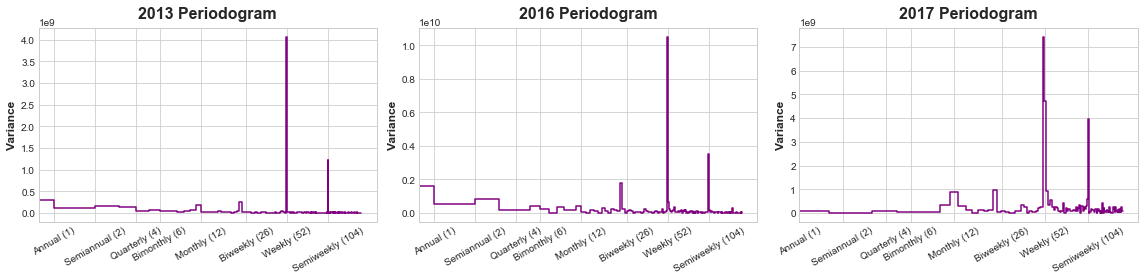

In [24]:
# train_data.groupby('date').sum().squeeze().loc['2013'].sales
sales_2013 = sales_grouped.loc[sales_grouped.year == 2013]
sales_2016 = sales_grouped.loc[sales_grouped.year == 2016]
sales_2017 = sales_grouped.loc[sales_grouped.year == 2017]

figsize = (16, 4)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
plot_periodogram(sales_2013.sales, ax=ax1, atext="2013")
plot_periodogram(sales_2016.sales, ax=ax2, atext="2016")
plot_periodogram(sales_2017.sales, ax=ax3, atext="2017")
plt.show()

### Conclusion: Periodograms

Based on these periodograms:
1. There are strong patterns of weekly frequency. 
2. The semi-weekly patterns were also found in the previous analysis.
3. There were weak patterns of monthly and bimonthly frequencies.
4. There was a slight impact on the annual frequency

<hr style="height:2px;border-width:0;color:black;background-color:black">

# Transaction Analysis

This feature is highly correlated with sales. More transactions often mean more sales.

In [25]:
top_stores_by_sale = sales_by_store_id.index[0:10].values
print("Top stores are: {}".format(top_stores_by_sale))

Top stores are: [44 45 47  3 49 46 48 51  8 50]


In [26]:
transaction_top_stores = transactions_data.drop(
    transactions_data[
        ~transactions_data.store_nbr.isin(top_stores_by_sale)
    ].index
)
top_stores_by_sale_r = pd.Series(
    range(len(top_stores_by_sale)), index=top_stores_by_sale
).to_dict()
transaction_top_stores["top"] = transactions_data.store_nbr.map(
    top_stores_by_sale_r
)
transaction_top_stores.sort_values(["top", "date"], inplace=True)

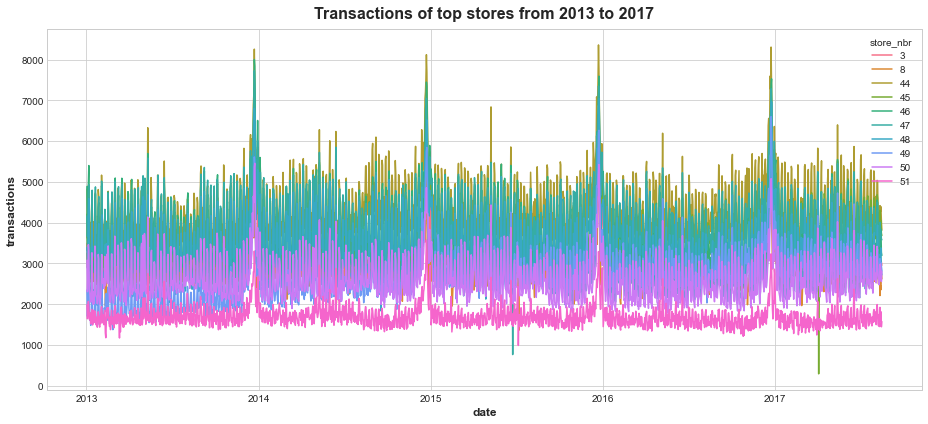

In [27]:
figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(
    data=transaction_top_stores,
    x="date",
    y="transactions",
    hue="store_nbr",
    ax=ax,
    palette=sns.color_palette("husl", n_colors=len(top_stores_by_sale)),
)
ax.set(title="Transactions of top stores from 2013 to 2017")
plt.show()

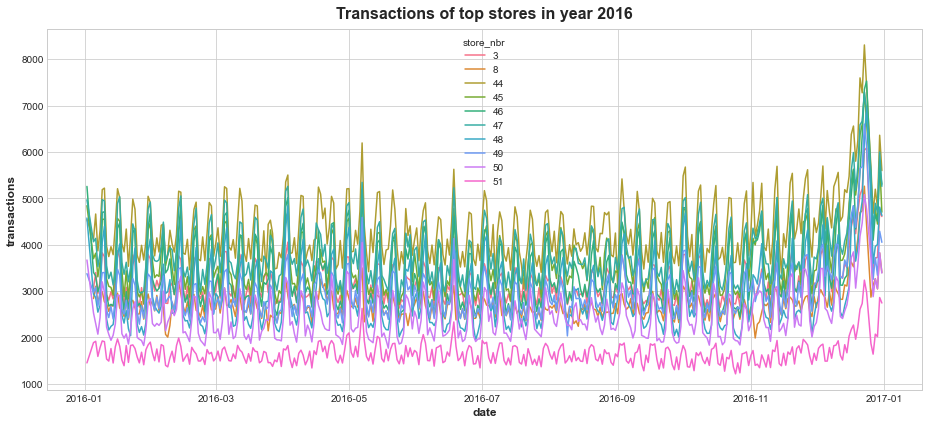

In [28]:
transaction_top_stores["year"] = transaction_top_stores.date.dt.year
transaction_top_stores["month"] = transaction_top_stores.date.dt.month
transaction_top_stores["dayofmonth"] = transaction_top_stores.date.dt.day
transaction_top_stores["dayofweek"] = transaction_top_stores.date.dt.dayofweek

figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(
    data=transaction_top_stores[
        (transaction_top_stores["year"] == 2016)
    ],  # &(transaction_top_stores['month']==5)
    x="date",
    y="transactions",
    hue="store_nbr",
    ax=ax,
    palette=sns.color_palette("husl", n_colors=len(top_stores_by_sale)),
)

ax.set(title="Transactions of top stores in year 2016")
plt.show()

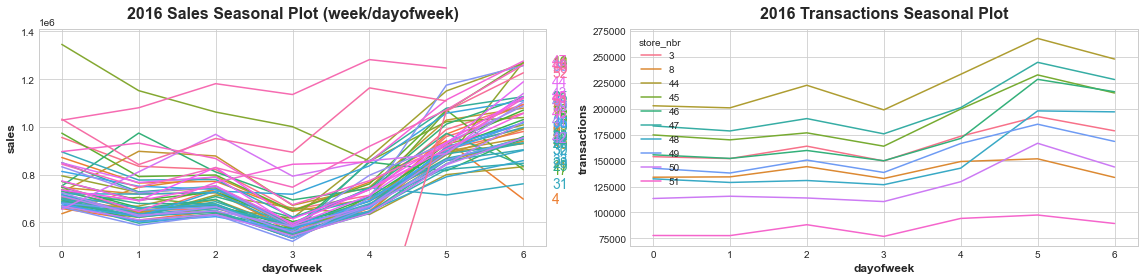

In [29]:
trans_2016 = (
    transaction_top_stores.loc[transaction_top_stores.year == 2016]
    .groupby(["dayofweek", "store_nbr"])
    .agg({"transactions": "sum"})
    .reset_index()
)
figsize = (16, 4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
seasonal_plot(
    sales_grouped.loc[sales_grouped["year"] == 2016],
    y="sales",
    period="week",
    freq="dayofweek",
    ax=ax1,
    atext="2016 Sales",
)
sns.lineplot(
    data=trans_2016,
    ax=ax2,
    x="dayofweek",
    y="transactions",
    hue="store_nbr",
    palette=sns.color_palette("husl", n_colors=len(top_stores_by_sale)),
)
ax1.set(ylim=5e5)
ax2.set(title="2016 Transactions Seasonal Plot")
plt.show()

## Notice

We can see the similarities between Sales and Transactions. Let's calculate their correlation coefficient.

## Spearman Correlation

In [30]:
temp = pd.merge(
    train_data.groupby(["date", "store_nbr"]).sales.sum().reset_index(),
    transactions_data,
    how="left",
)
print(
    "Spearman Correlation between Total Sales and Transactions: "
    + "{:,.2f}".format(temp.corr("spearman").sales.loc["transactions"])
)

Spearman Correlation between Total Sales and Transactions: 0.82


In [31]:
print(
    "Spearman Correlation between Total Sales and Transactions: "
    + f'{temp.corr("spearman").sales.loc["transactions"]:,.2f}'
)

Spearman Correlation between Total Sales and Transactions: 0.82


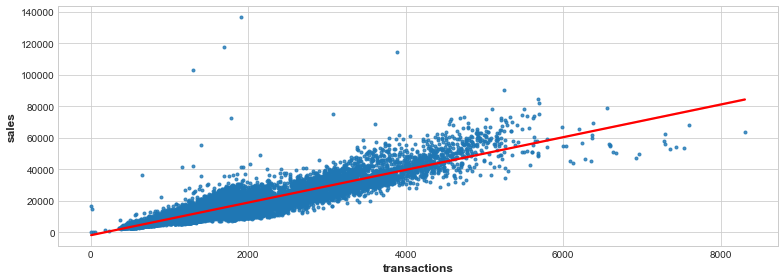

In [32]:
sns.regplot(
    data=temp.loc[temp.date.dt.year == 2016],
    x="transactions",
    y="sales",
    marker=".",
    line_kws={"color": "r"},
)
plt.show()

A high value of Spearman Correlation shows that there is a strong correlation between Sales and Transactions.

<hr style="height:2px;border-width:0;color:black;background-color:black">

# Autocorrelation

In [33]:
# We want to remove outlier to make graph better understanding
from scipy import stats


def outlierFilter(df, columns=""):
    # calculate z-scores of df and remove row where zscore is high
    if columns:
        return df[(np.abs(stats.zscore(df[columns])) < 3)]
    else:
        return df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

## Lags in different years

2013: Number of outlier points: 5 / total points 364
2016: Number of outlier points: 2 / total points 365
2017: Number of outlier points: 3 / total points 227


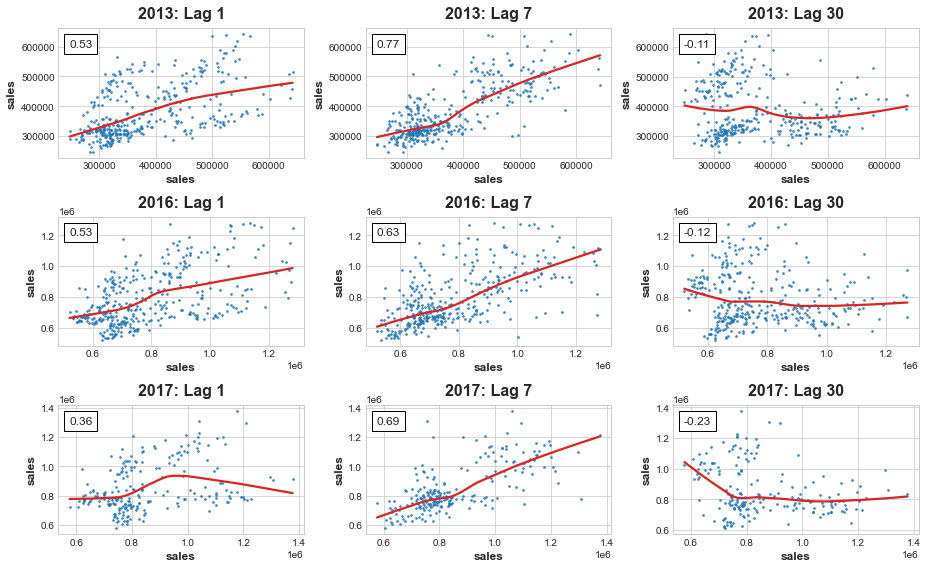

In [34]:
acs = {
    "2013": sales_2013.copy(),
    "2016": sales_2016.copy(),
    "2017": sales_2017.copy(),
}
figsize = (13, 8)
fig, ax = plt.subplots(3, 3, figsize=figsize)
i = 0
for year in acs:
    ac = outlierFilter(
        acs[year], "sales"
    )  # Remove outlier to make graph better understanding
    print(
        "{}: Number of outlier points: {} / total points {}".format(
            year, len(acs[year].index) - len(ac.index), len(acs[year].index)
        )
    )
    ac = ac.loc[ac.sales > 1e5]  # Remove outliers
    lagplot(ac["sales"], shift=1, ax=ax[i, 0], atext=year)
    lagplot(ac["sales"], shift=7, ax=ax[i, 1], atext=year)
    lagplot(ac["sales"], shift=30, ax=ax[i, 2], atext=year)
    i += 1

plt.show()

In [35]:
ac = sales_2017.copy()
ac = outlierFilter(ac, "sales")
ac["lag_week"] = ac.sales.shift(7)
ac["lag_1day"] = ac.sales.shift(1)
ac["lag_30day"] = ac.sales.shift(30)
printmd("**For sales in 2017:**")
print(
    "Spearman Correlation: Sales vs lag_week: {:,.2f}".format(
        ac.corr("spearman").sales["lag_week"]
    )
)
print(
    "Spearman Correlation: Sales vs lag_1day: {:,.2f}".format(
        ac.corr("spearman").sales["lag_1day"]
    )
)
print(
    "Spearman Correlation: Sales vs lag_30day: {:,.2f}".format(
        ac.corr("spearman").sales["lag_30day"]
    )
)

**For sales in 2017:**

Spearman Correlation: Sales vs lag_week: 0.65
Spearman Correlation: Sales vs lag_1day: 0.36
Spearman Correlation: Sales vs lag_30day: -0.17


### Conclusion

There were a strong Lag 1 and the strongest Lag 7-day.

## Deseasonalized

By removing the impact of seasonality, we will see how each family of products shows cyclic patterns.

In [36]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


def create_date_features(df):
    df = df.to_timestamp()
    df["is_month_start"] = df.index.is_month_start.astype("int8")
    df["is_month_end"] = df.index.is_month_end.astype("int8")
    df["is_year_start"] = df.index.is_year_start.astype("int8")
    df["is_year_end"] = df.index.is_year_end.astype("int8")
    df = df.to_period("D")
    return df

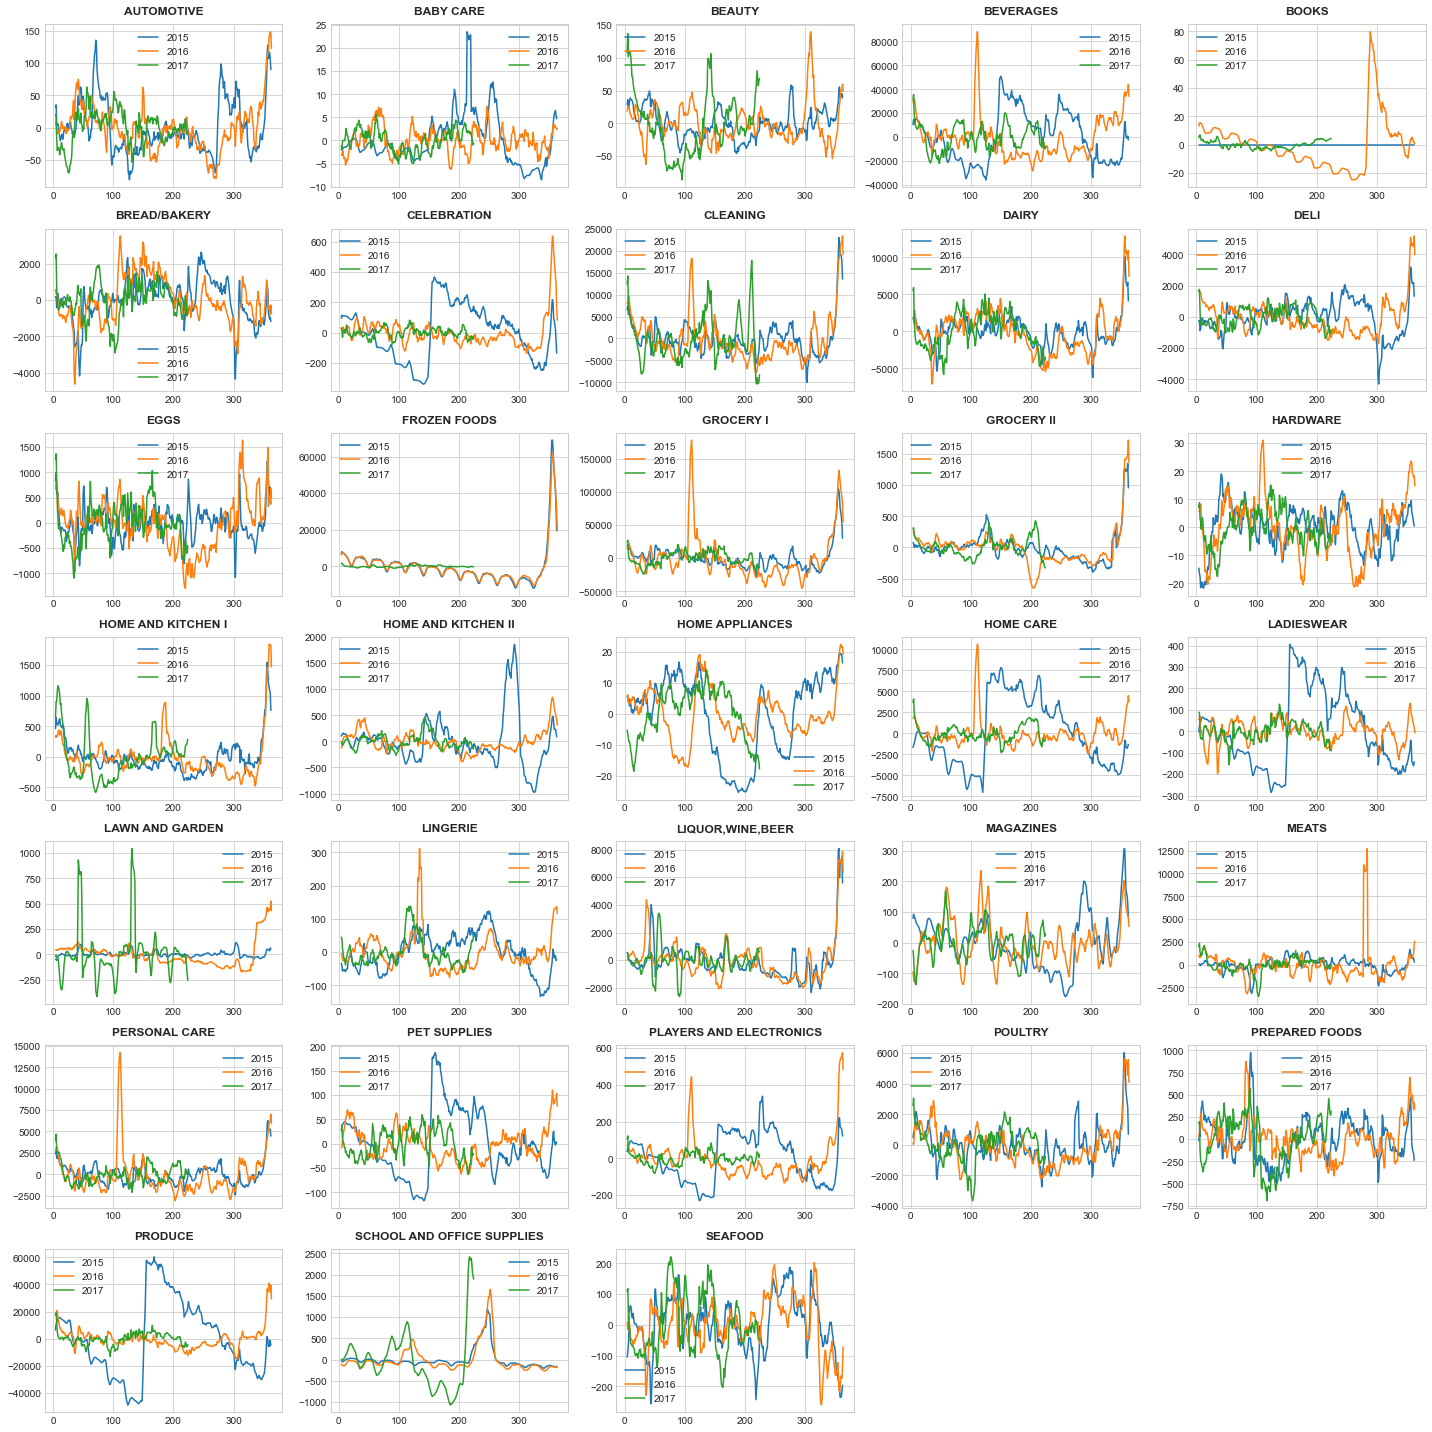

In [37]:
fig, axes = plt.subplots(7, 5, figsize=(20, 20))
years = ["2015", "2016", "2017"]  # "2013","2014",
family_sales_all = (
    train_data.groupby(["family", "date"])
    .sum()
    .unstack("family")
    .to_period("D")
)
family_sales_all["dayofyear"] = family_sales_all.index.dayofyear
x = range(365)
for year in years:
    family_sales = family_sales_all.loc[
        year, ["sales", "onpromotion", "dayofyear"]
    ]
    for i, family in enumerate(family_unique):
        supply_sales = family_sales.loc(axis=1)[:, family]
        y = supply_sales.loc[:, "sales"].squeeze()

        fourier = CalendarFourier(freq="M", order=4)
        dp = DeterministicProcess(
            constant=True,
            index=y.index,
            order=1,
            seasonal=True,
            drop=True,
            additional_terms=[fourier],
        )
        X_time = dp.in_sample()
        # X_time['NewYearsDay']  = (X_time.index.dayofyear == 1)
        X_time = create_date_features(X_time)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_time, y)
        y_deseason = y - model.predict(X_time)
        y_deseason = y_deseason.rolling(7, center=True).mean()
        y_deseason.name = "sales_deseasoned"
        # y_deseason.plot(x='dayofyear', ax=axes[(i//5), i%5])
        axes[(i // 5), i % 5].plot(
            family_sales["dayofyear"], y_deseason, label=year
        )
        axes[(i // 5), i % 5].set_title("{}".format(family), fontsize=12)
        axes[(i // 5), i % 5].legend()

fig.delaxes(axes[6][3])
fig.delaxes(axes[6][4])
plt.show()

### Conclusion

By deseasonalizing (weekly and monthly) and comparing to different years, we see other patterns for some product families and some cases where the behaviors are `irregular variations`. For examples:

* Lingerie: rose at the beginning and the end of summers perhaps due to the on-sale clearances.
* Prepared Foods: between March to May. I do not come up with a reason.
* School and office supplies: Obviously the needs suddenly jumped at the beginning of every academic year.
* Seafood: We see a lot of fluctuations there, which need to be carefully modeled.

### Irregular variations

When comparing different years, we found there are a couple of abnormal peaks and troughs. By analyzing these irregularities, we could learn and improve the business.

# ACF and PACF Plots

To understand more about `Autocorrelation`, we investigate sales with ACF (a complete auto-correlation function) and PACF (a partial auto-correlation function) Plots. Based on that, we can determine the orders of auto-regressive (AR) and moving average (MA),i.e., calculate values of p and q in (p,d,q)m to feed into the AR-I-MA model (for seasonal time series). `p` for AR part, `q` for MA part, `d` is order of I (itegrative) part - a number of times to achieve stationary.

In this case of seasonal time series for sales, ACF shows Geometric Decat at each `m` Lag for AR and significant at `m` Lag for MA; invesely, PACF reverses this order.

Furthermore, contrary to ACF where all correlations are found for original data, PACF finds the correlation of present and then correlation of residuals (which remains after explained by previous correlations). Hence, by analyzing PACF, we can select which families and their values of lag. Read more about AR, MA, ACF, PCF [here](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8).

For example, if we found a `significant lag` _"x"_ which is significant in ACF, we should see geometric decays at Lag _2x, 3x, 4x_ and so on in PACF.


In [38]:
# PACF - ACF
import statsmodels.api as sm

In [39]:
grouped_by_family = (
    train_data[(train_data.sales.notnull())]
    .groupby(["date", "family"])
    .sales.mean()
    .reset_index()
    .set_index("date")
)

family_unique = grouped_by_family.family.unique()

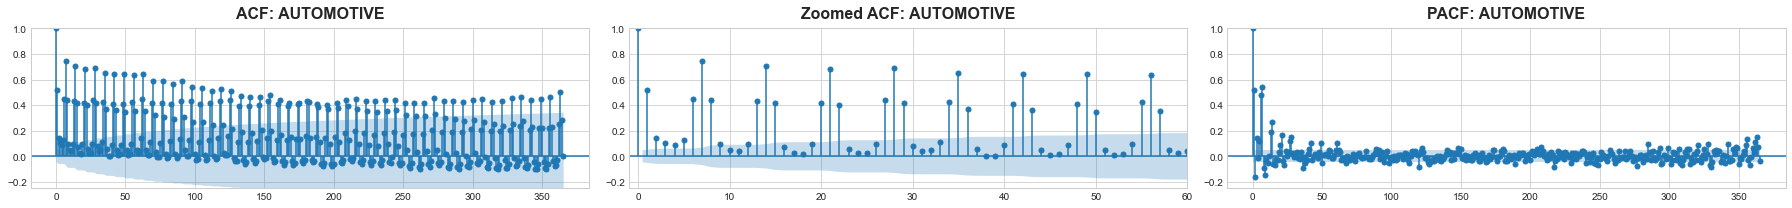

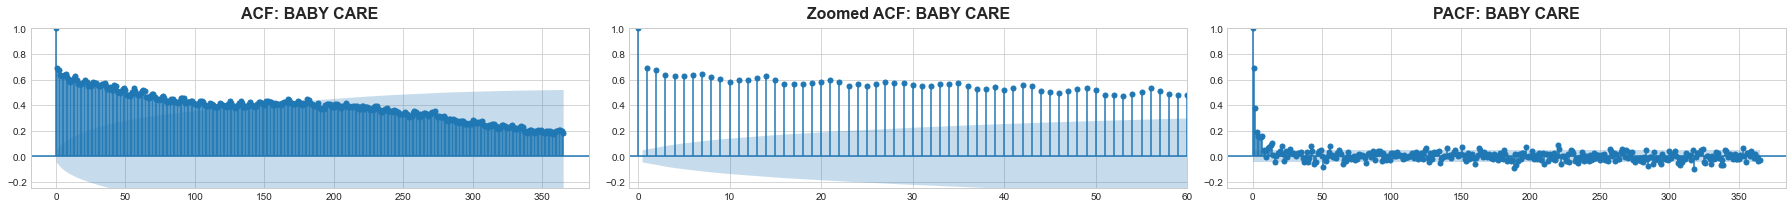

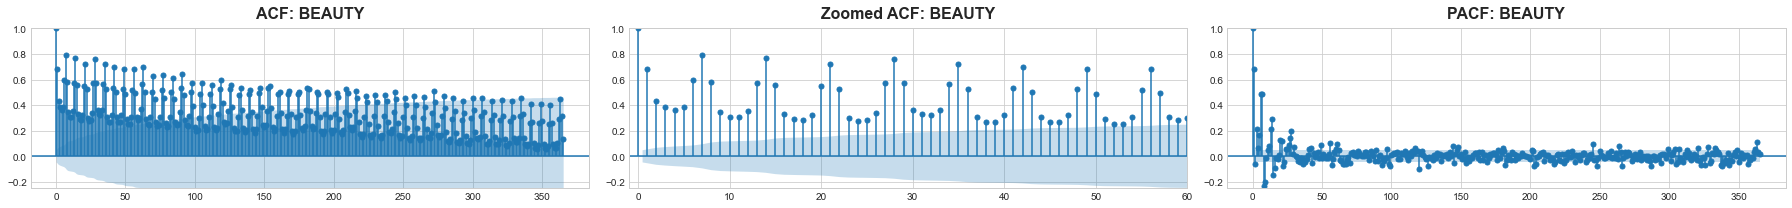

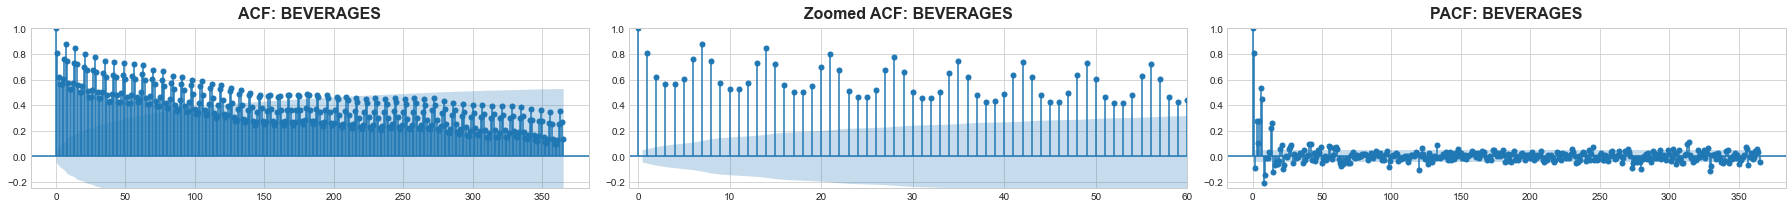

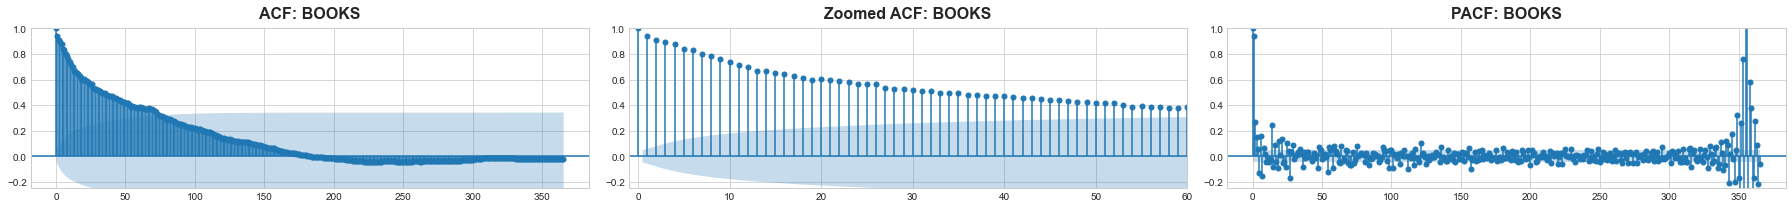

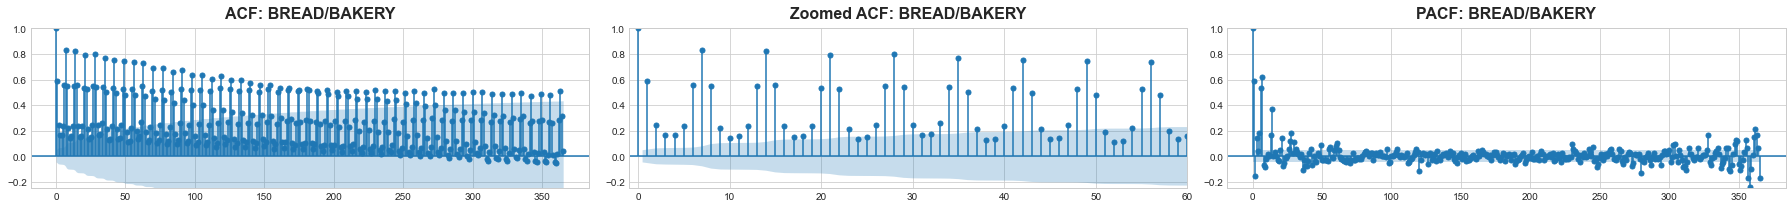

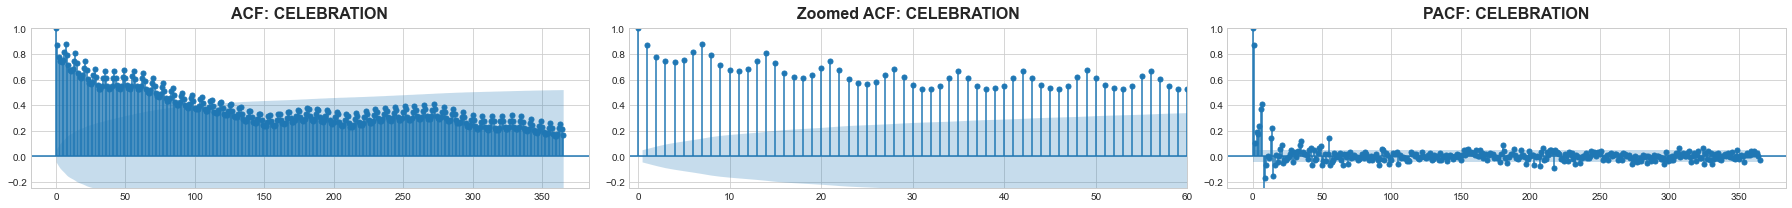

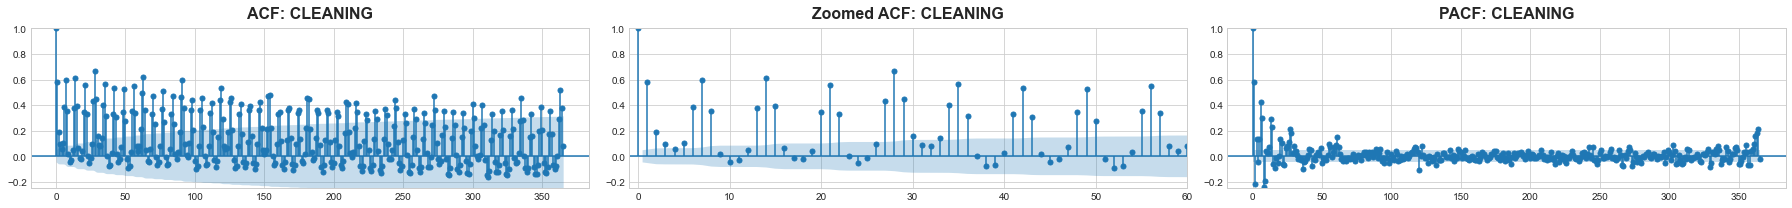

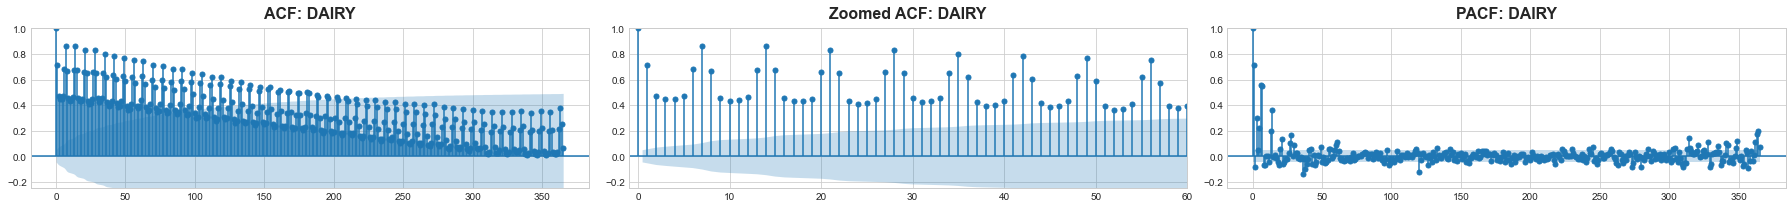

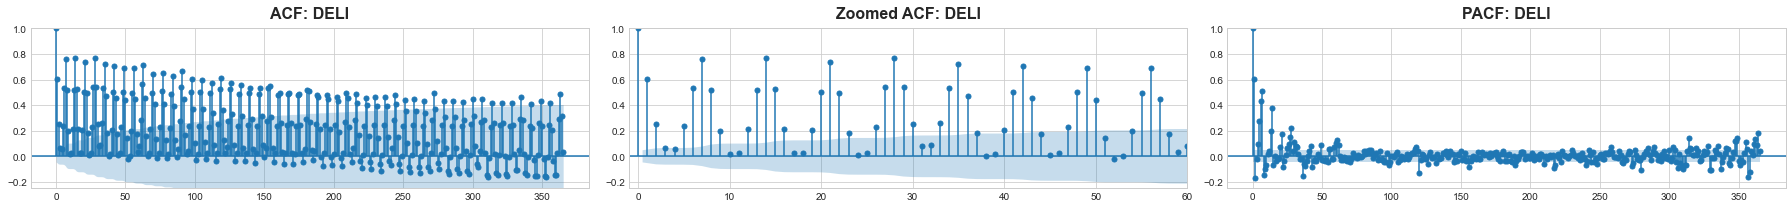

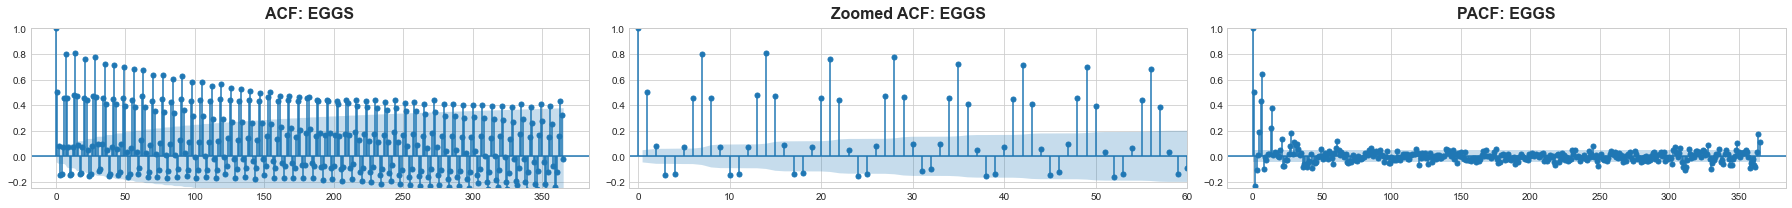

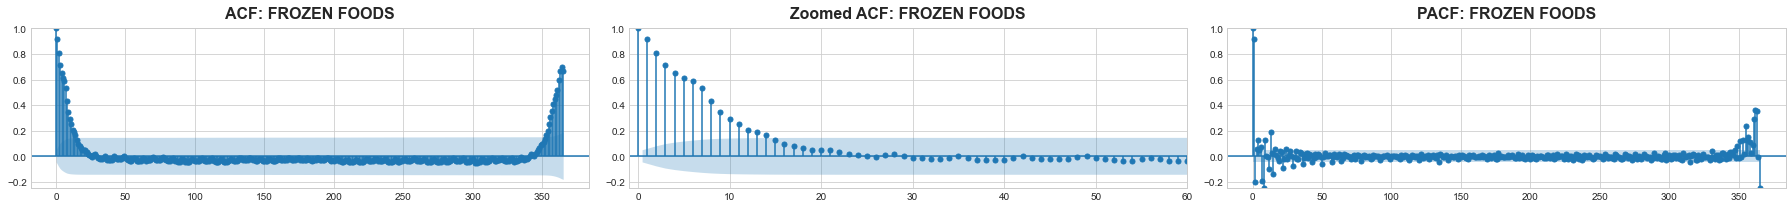

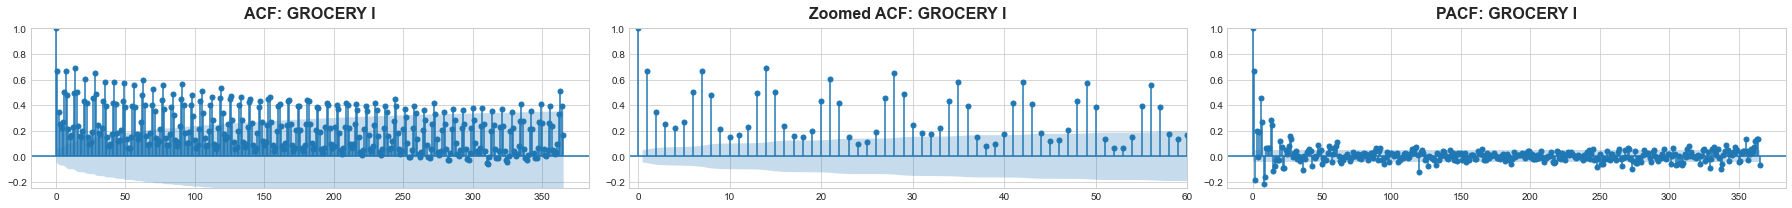

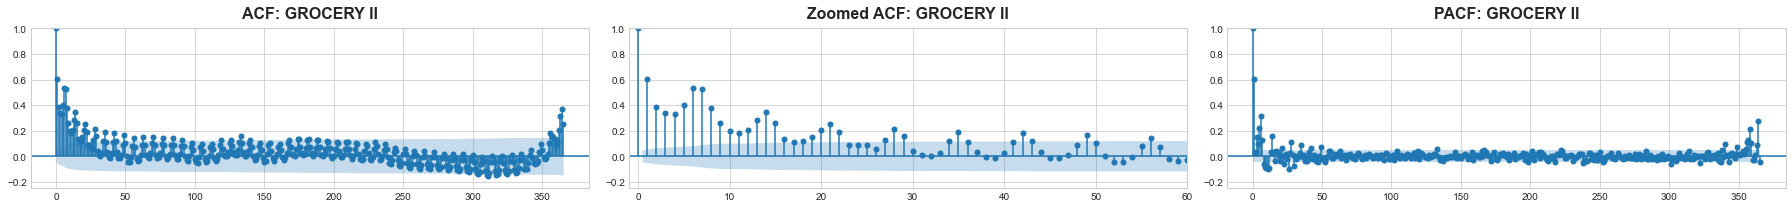

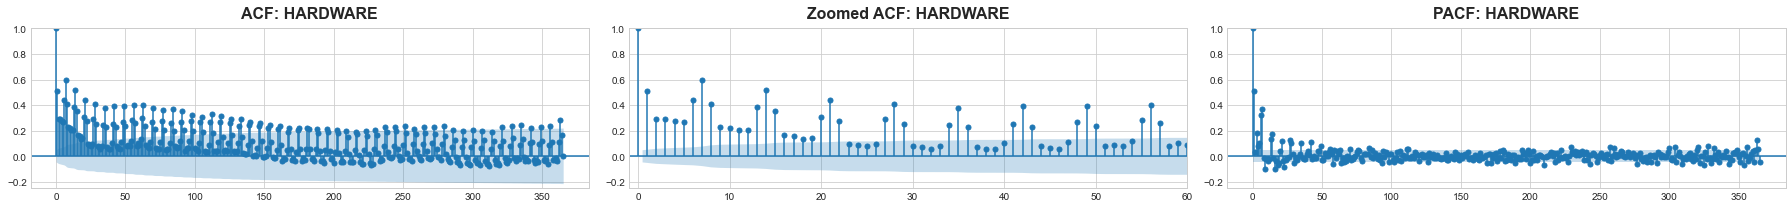

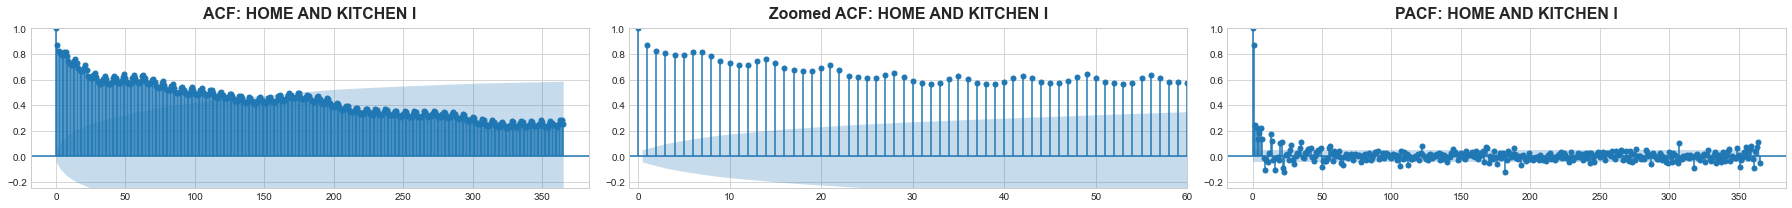

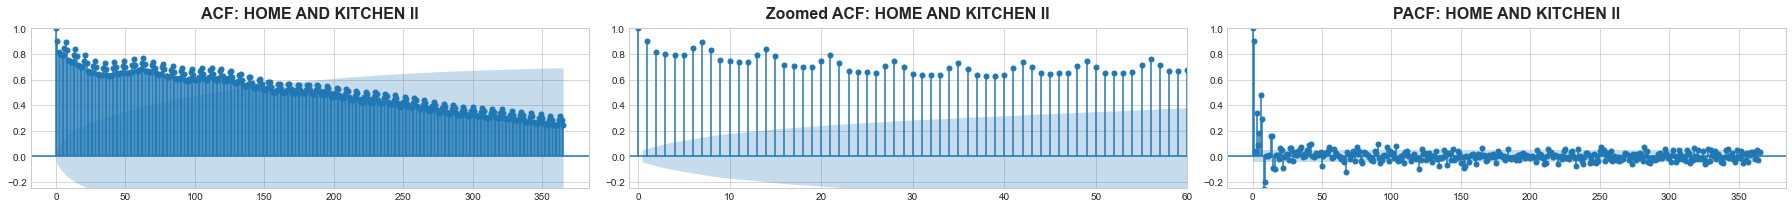

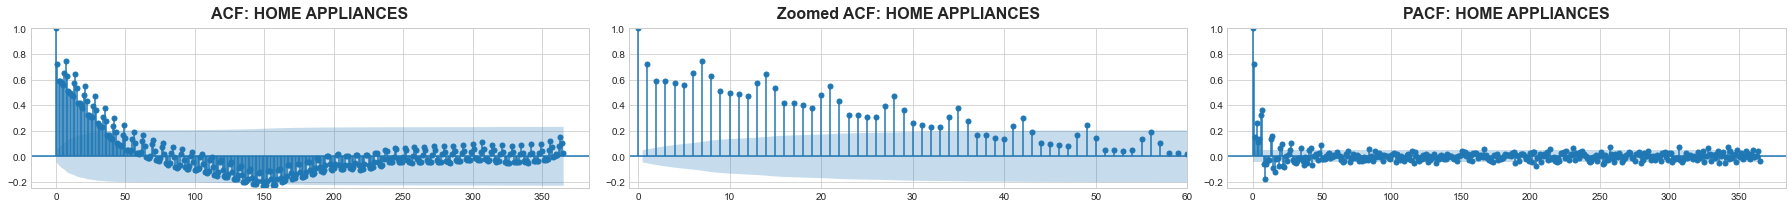

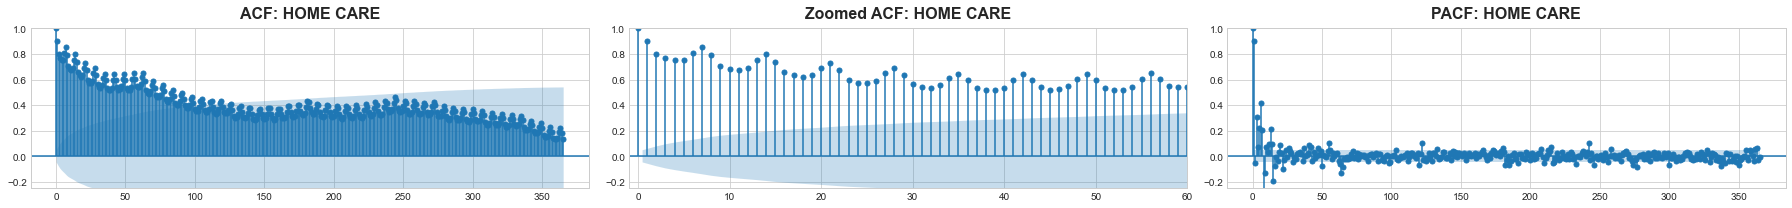

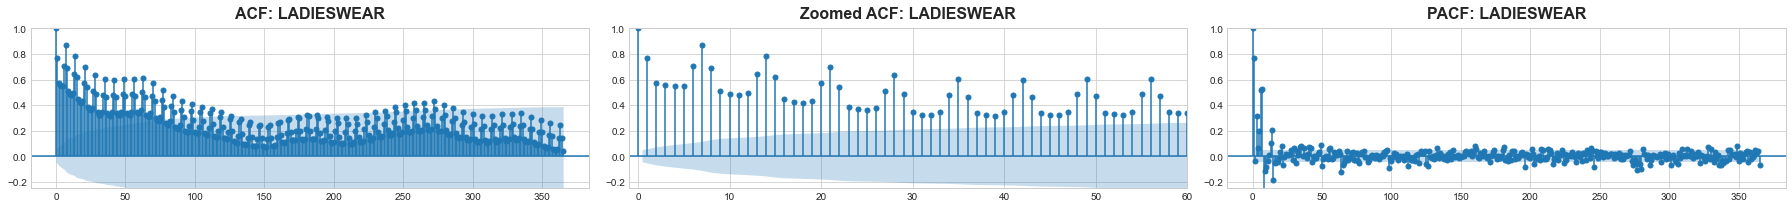

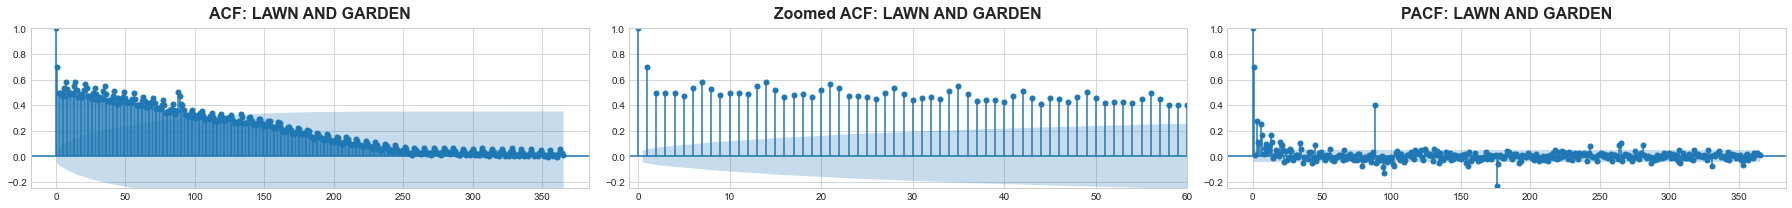

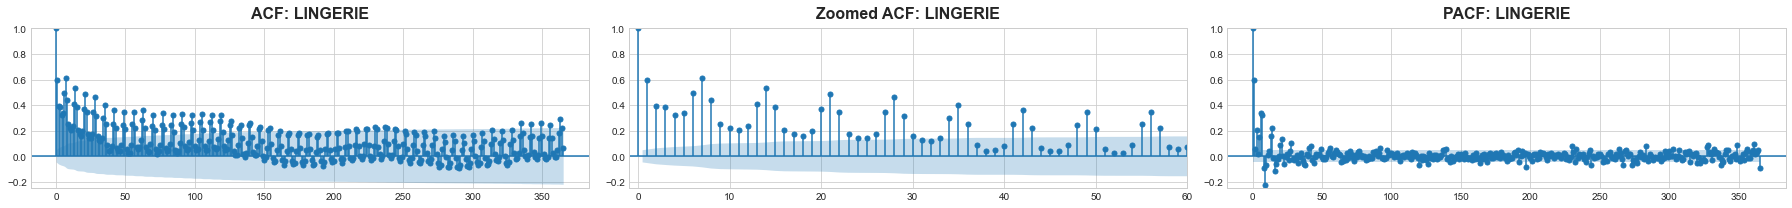

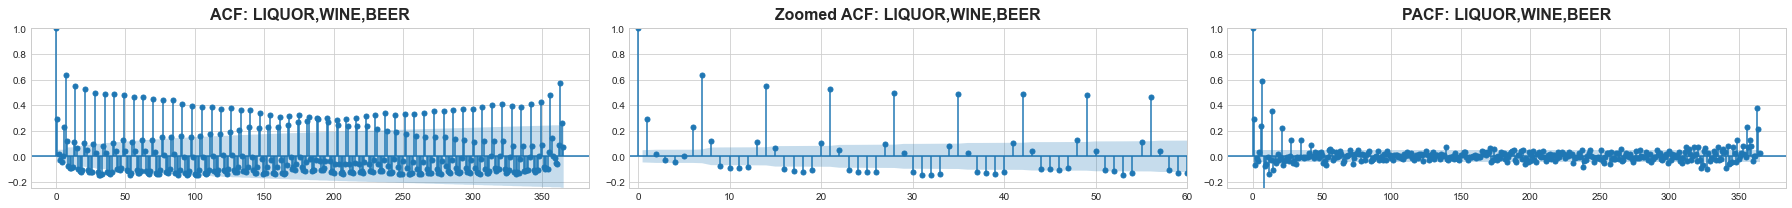

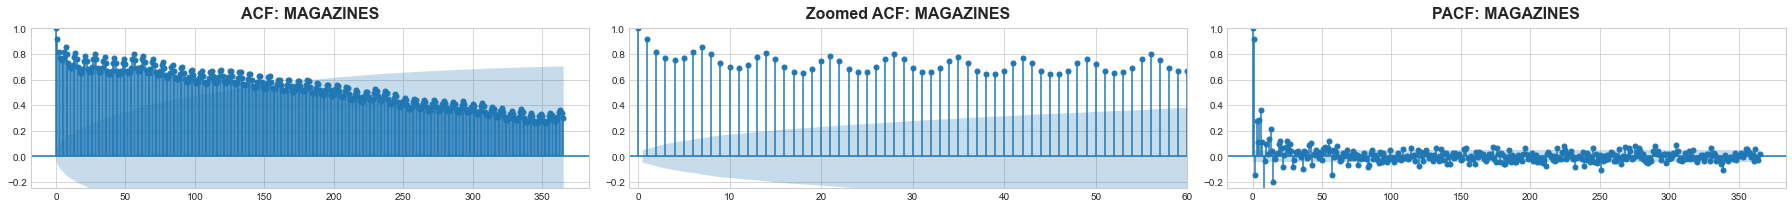

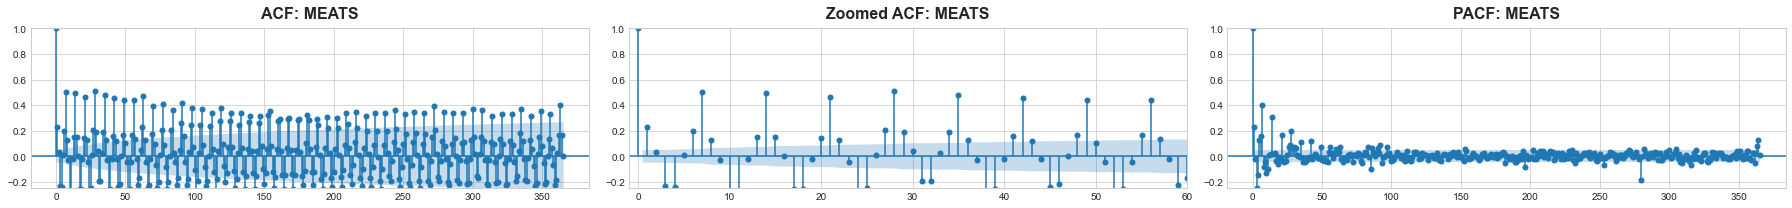

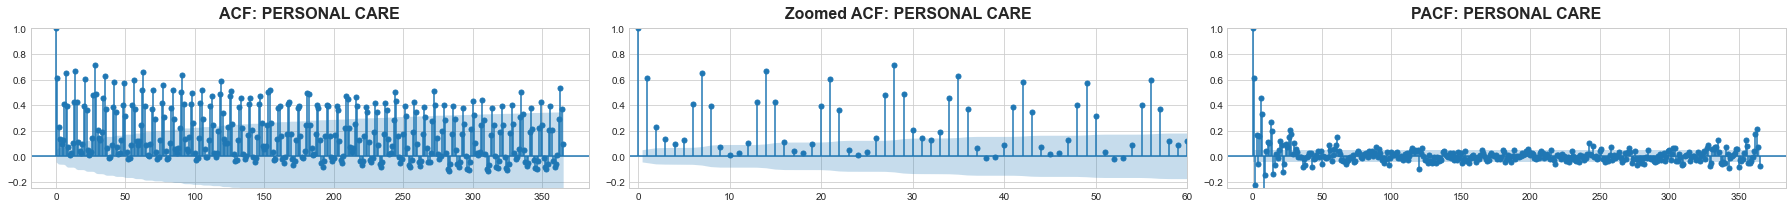

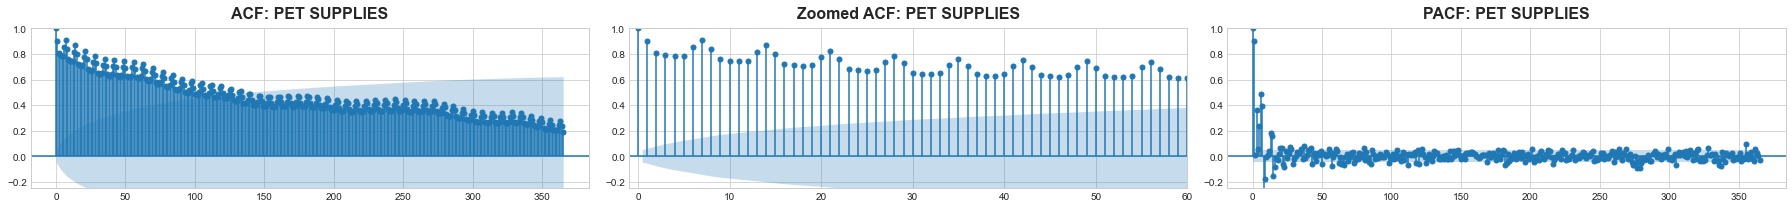

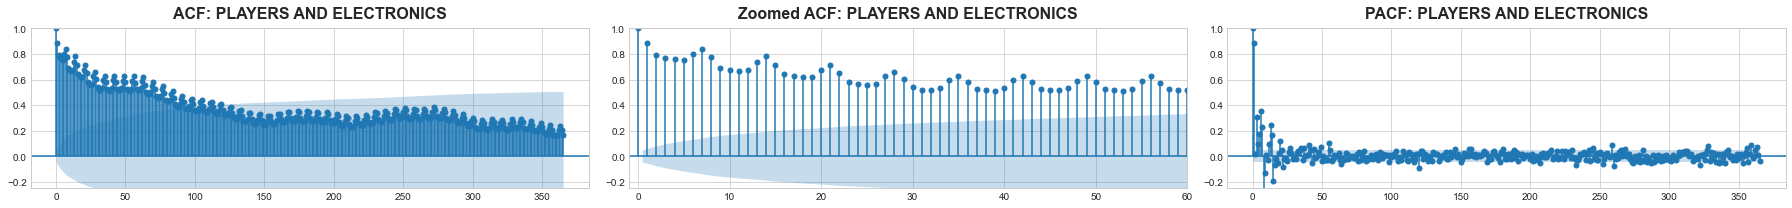

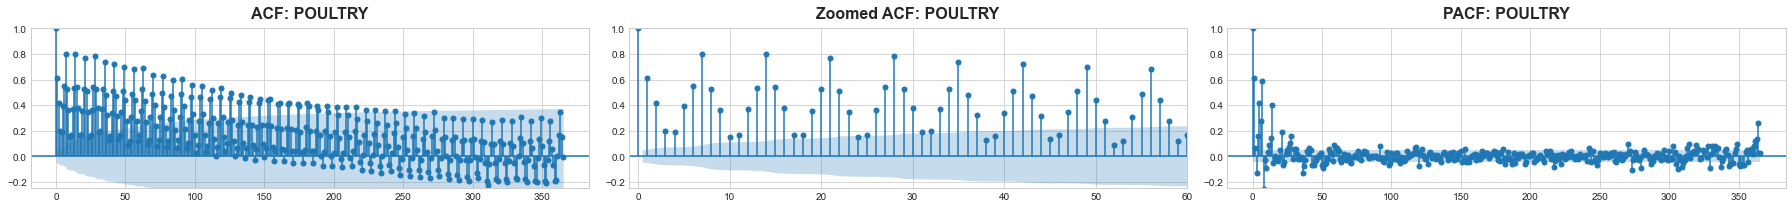

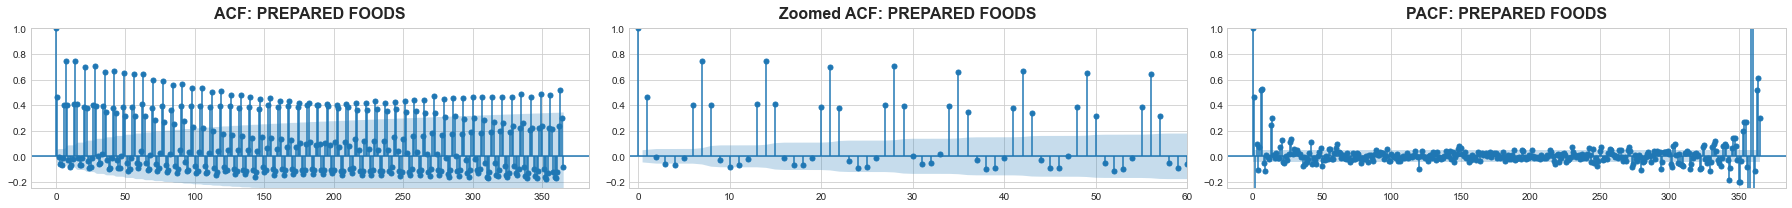

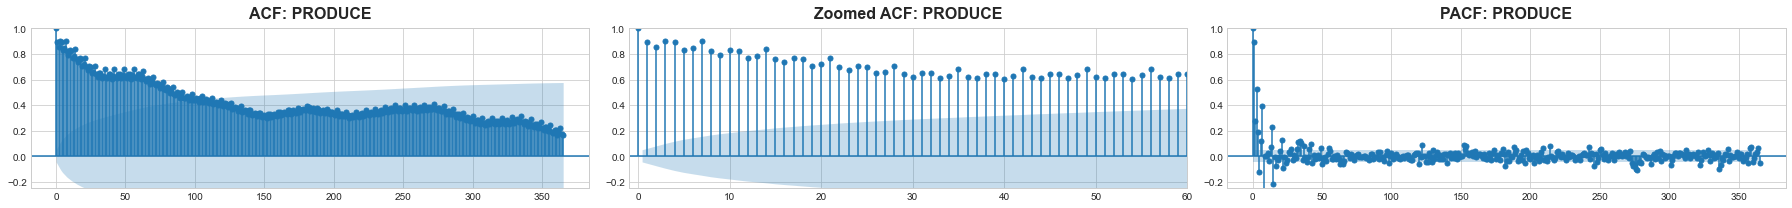

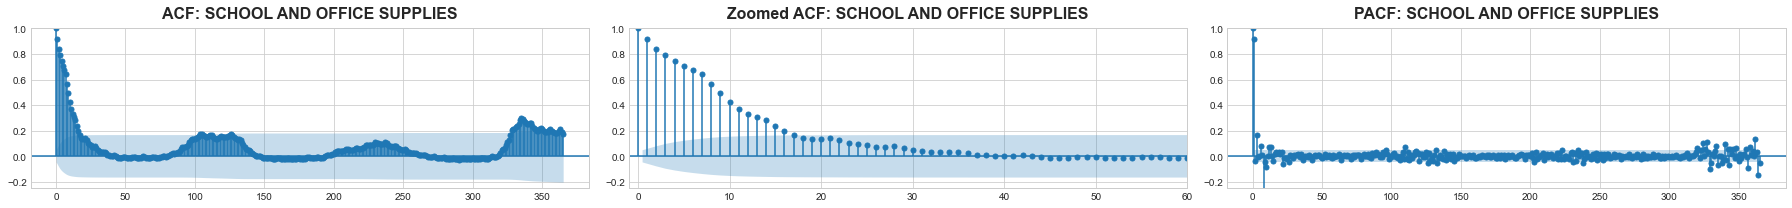

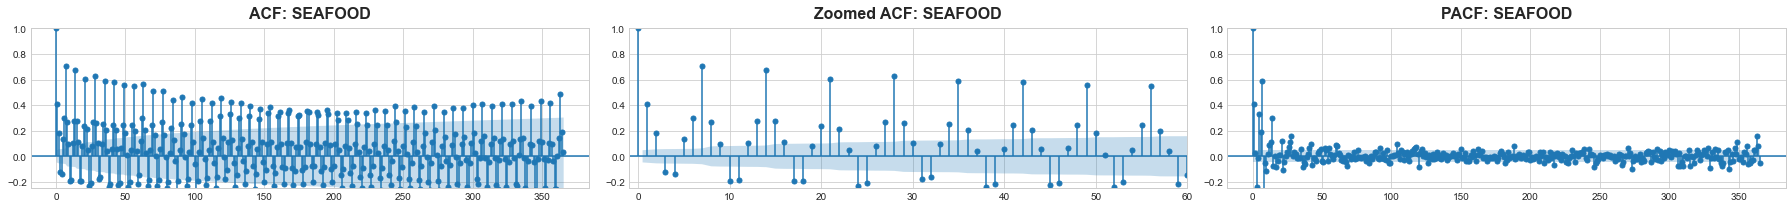

In [40]:
for num, i in enumerate(family_unique):
    fig, ax = plt.subplots(1, 3, figsize=(25, 3))
    temp = grouped_by_family[(grouped_by_family.family == i)]
    sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[0], title="ACF: " + i)
    sm.graphics.tsa.plot_acf(
        temp.sales, lags=365, ax=ax[1], title="Zoomed ACF: " + i
    )
    sm.graphics.tsa.plot_pacf(
        temp.sales, lags=365, ax=ax[2], title="PACF: " + i
    )

    ax[0].set(ylim=[-0.25, 1])
    ax[1].set(xlim=[-1, 60], ylim=[-0.25, 1])
    ax[2].set(ylim=[-0.25, 1])

plt.show()

### Conclusion

Most product families have a strong correlation with Lag 7-day or weekly frequency. They are clearly seasonal time series where the geometric decay repeats every 7-day Lag in ACF.

However, some of them show weak correlations, for example, Baby Care, Celebration, Home and Kitchen I & II, Home care, Lawn and Garden, Magazines, Pet supplies, Players and Electronics, Produce. The needs of these products are a must, i.e., when someone needs them, one will probably go and buy them right away, instead of waiting until the weekend. Hence, they are non-seasonal time series.

In addition, we see some strong dependence on the frequency of 365-day such as Books, Frozen Foods, Liquor Wine Beer, Prepared Foods, School and Office Supplies. People often stock up on these products at special events or on holidays such as the end of a year or the beginning of an academic year. However, we can consider them as cyclic fluctuations with annual frequency.

By understanding well these behaviors, we can model better our data to predict more accurately.